In [ ]:
%cd "/content/drive/MyDrive/atnlp"

/content/drive/MyDrive/atnlp


# Exam Assignment 3: Experiment 1:  Generalizing to a random subset of commands

In [ ]:
# importing libraries 
import sys

from Dataset import SCANDataset, basic_tokenizer, tokenizer_bart, collate_fn
from Utils import load_vocab, parse_dataset, split_dataset, create_dataloader, plot_metrics, train_and_validate, evaluate_model, train_bart, evaluate_bart, evaluate_modelbart
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.nn.utils import clip_grad_norm_
import random
from torch.utils.data import DataLoader, RandomSampler, Subset
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

### Loading vocabulary and Tokenizer from Bart 

In [ ]:
# loading vocab
input_vocab, output_vocab = load_vocab()

In [ ]:
input_vocab_list = ['<PAD>','twice', 'and', 'look',  'thrice', 'left', 'turn', 'jump', 'run', 'opposite', 'walk', 'after', 'around', 'right', '<EOS>']
tokenizer = tokenizer_bart(input_vocab_list)


### Loading Pre-trained BART model <br/>
Changing config of bart to match the given config of experiment 1 and to finetune BART. 

In [ ]:

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
# Resize model's embeddings to accommodate new tokens
model.resize_token_embeddings(len(tokenizer))

# Modify specific parameters in the model's config
model.config.max_position_embeddings = 128  # Update max sequence length
model.config.pad_token_id = tokenizer.pad_token_id
model.config.decoder_start_token_id = tokenizer.pad_token_id
model.model.encoder.layers = model.model.encoder.layers[:2]


# Print the updated configuration
print("Updated Configuration:", model.config)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Updated Configuration: BartConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 50265,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
 

In [ ]:
# Modify the configuration
# Reduce the number of decoder layers
model.model.decoder.layers = model.model.decoder.layers[:2]

# Update config to reflect the changes
model.config.d_model = 128  # Set the new d_model (embedding size)
model.config.encoder_layers = 1
model.config.decoder_layers = 1
model.config.encoder_attention_heads = 8  # Number of attention heads in the encoder
model.config.decoder_attention_heads = 8  # Number of attention heads in the decoder
model.config.dropout = 0.05               # Dropout rate
model.config.encoder_ffn_dim = 512        # Feedforward dimension in the encoder
model.config.decoder_ffn_dim = 512        # Feedforward dimension in the decoder
# Print updated configuration
print("Updated Configuration:", model.config)

Updated Configuration: BartConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 128,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 512,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 1,
  "decoder_start_token_id": 50265,
  "dropout": 0.05,
  "early_stopping": true,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 512,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 1,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr = 7e-4 )
criterion = torch.nn.CrossEntropyLoss(ignore_index=output_vocab["<PAD>"])
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50270, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50270, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-1): 2 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

### Data Loading <br/>
Data is loaded and preprocessed as train and validation sets 

In [ ]:
full_data= parse_dataset('data/tasks.txt', input_vocab, output_vocab)
#full_dataset = SCANDataset(full_data, input_vocab, output_vocab, tokenizer)

# Train val split '

train_set, val_set = split_dataset(full_data)
train_dataset = SCANDataset(train_set, input_vocab, output_vocab, tokenizer)
val_dataset = SCANDataset(val_set, input_vocab, output_vocab, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn = collate_fn)


In [ ]:
# Size variation for experiment 1
proportions = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.0]

In [ ]:
def get_proportion_loader(dataset, proportions, batch_size, shuffle=True):
    subset_size = int(len(dataset) * proportions)
    indices = list(range(len(dataset)))
    subset_indices = indices[:subset_size]
    subset = Subset(dataset, subset_indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

### Training and Validating the data 

In [ ]:
epochs=10
batch_size=64
lr= 7e-4
results= {}
grad_clip = 1.0
teacher_forcing_ratio = 0.5 #For evaluation
token_accuracies = []
seq_accuracies = []

for prop in proportions:

    for epoch in range(epochs):
      print(f"\nTraining with {prop * 100:.0f}% of the data")
      train_loss = train_bart(model, train_loader, optimizer, device, grad_clip=1.0)
      print(f"Epoch {epoch+1}/{10}, Training Loss: {train_loss:.4f}")

      val_loss, token_acc, seq_acc = evaluate_modelbart(
          model,
          val_loader,
          optimizer,
          device,
          grad_clip=1.0

          )
    print(f"Validation Loss: {val_loss:.4f}, Token Accuracy: {token_acc:.4f}, Sequence Accuracy: {seq_acc:.4f}")
    token_accuracies.append(token_acc)
    seq_accuracies.append(seq_acc)


    # Calculate the average accuracy over the repetitions
    avg_token_acc = sum(token_accuracies) / len(token_accuracies)
    avg_seq_acc = sum(seq_accuracies) / len(seq_accuracies)
    # Store the results in the dictionary
    results[prop] = [avg_token_acc, avg_seq_acc]


    print(f"Test Token-Level Accuracy: {token_acc:.8f}")
    print(f"Test Sequence-Level Accuracy: {seq_acc:.8f}")

# Print the results
for num, accuracies in results.items():
    print(f"Size subset: {num}, Token Accuracy: {accuracies[0]:.8f}, Sequence Accuracy: {accuracies[1]:.8f}")

    # Store the results in the dictionary
    results[num] = [avg_token_acc, avg_seq_acc]



Training with 1% of the data


Average Training Loss: 0.0008
Epoch 1/10, Training Loss: 0.0008


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.86%

Training with 1% of the data


Average Training Loss: 0.0010
Epoch 2/10, Training Loss: 0.0010


Validation Loss: 0.0005, Token Accuracy: 99.99%, Sequence Accuracy: 98.52%

Training with 1% of the data


Average Training Loss: 0.0017
Epoch 3/10, Training Loss: 0.0017


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.71%

Training with 1% of the data


Average Training Loss: 0.0010
Epoch 4/10, Training Loss: 0.0010


Validation Loss: 0.0005, Token Accuracy: 99.99%, Sequence Accuracy: 98.57%

Training with 1% of the data


Average Training Loss: 0.0006
Epoch 5/10, Training Loss: 0.0006


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.88%

Training with 1% of the data


Average Training Loss: 0.0008
Epoch 6/10, Training Loss: 0.0008


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.52%

Training with 1% of the data


Average Training Loss: 0.0006
Epoch 7/10, Training Loss: 0.0006


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.95%

Training with 1% of the data


Average Training Loss: 0.0005
Epoch 8/10, Training Loss: 0.0005


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.90%

Training with 1% of the data


Average Training Loss: 0.0004
Epoch 9/10, Training Loss: 0.0004


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.74%

Training with 1% of the data


Average Training Loss: 0.0007
Epoch 10/10, Training Loss: 0.0007


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.83%
Validation Loss: 0.0000, Token Accuracy: 99.9985, Sequence Accuracy: 99.8326
Test Token-Level Accuracy: 99.99850550
Test Sequence-Level Accuracy: 99.83261597

Training with 2% of the data


Average Training Loss: 0.0006
Epoch 1/10, Training Loss: 0.0006


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.88%

Training with 2% of the data


Average Training Loss: 0.0007
Epoch 2/10, Training Loss: 0.0007


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.81%

Training with 2% of the data


Average Training Loss: 0.0005
Epoch 3/10, Training Loss: 0.0005


Validation Loss: 0.0004, Token Accuracy: 99.99%, Sequence Accuracy: 99.16%

Training with 2% of the data


Average Training Loss: 0.0009
Epoch 4/10, Training Loss: 0.0009


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.76%

Training with 2% of the data


Average Training Loss: 0.0010
Epoch 5/10, Training Loss: 0.0010


Validation Loss: 0.0010, Token Accuracy: 99.97%, Sequence Accuracy: 98.30%

Training with 2% of the data


Average Training Loss: 0.0009
Epoch 6/10, Training Loss: 0.0009


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.90%

Training with 2% of the data


Average Training Loss: 0.0006
Epoch 7/10, Training Loss: 0.0006


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.86%

Training with 2% of the data


Average Training Loss: 0.0007
Epoch 8/10, Training Loss: 0.0007


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.81%

Training with 2% of the data


Average Training Loss: 0.0007
Epoch 9/10, Training Loss: 0.0007


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.81%

Training with 2% of the data


Average Training Loss: 0.0005
Epoch 10/10, Training Loss: 0.0005


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.81%
Validation Loss: 0.0001, Token Accuracy: 99.9983, Sequence Accuracy: 99.8087
Test Token-Level Accuracy: 99.99831869
Test Sequence-Level Accuracy: 99.80870397

Training with 4% of the data


Average Training Loss: 0.0013
Epoch 1/10, Training Loss: 0.0013


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.76%

Training with 4% of the data


Average Training Loss: 0.0006
Epoch 2/10, Training Loss: 0.0006


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.83%

Training with 4% of the data


Average Training Loss: 0.0004
Epoch 3/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.83%

Training with 4% of the data


Average Training Loss: 0.0005
Epoch 4/10, Training Loss: 0.0005


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.52%

Training with 4% of the data


Average Training Loss: 0.0006
Epoch 5/10, Training Loss: 0.0006


Validation Loss: 0.0002, Token Accuracy: 100.00%, Sequence Accuracy: 99.64%

Training with 4% of the data


Average Training Loss: 0.0008
Epoch 6/10, Training Loss: 0.0008


Validation Loss: 0.0003, Token Accuracy: 99.99%, Sequence Accuracy: 98.73%

Training with 4% of the data


Average Training Loss: 0.0008
Epoch 7/10, Training Loss: 0.0008


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.67%

Training with 4% of the data


Average Training Loss: 0.0006
Epoch 8/10, Training Loss: 0.0006


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.64%

Training with 4% of the data


Average Training Loss: 0.0016
Epoch 9/10, Training Loss: 0.0016


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.71%

Training with 4% of the data


Average Training Loss: 0.0009
Epoch 10/10, Training Loss: 0.0009


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.64%
Validation Loss: 0.0001, Token Accuracy: 99.9972, Sequence Accuracy: 99.6413
Test Token-Level Accuracy: 99.99719781
Test Sequence-Level Accuracy: 99.64131994

Training with 8% of the data


Average Training Loss: 0.0005
Epoch 1/10, Training Loss: 0.0005


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.64%

Training with 8% of the data


Average Training Loss: 0.0004
Epoch 2/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.93%

Training with 8% of the data


Average Training Loss: 0.0006
Epoch 3/10, Training Loss: 0.0006


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.64%

Training with 8% of the data


Average Training Loss: 0.0004
Epoch 4/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.83%

Training with 8% of the data


Average Training Loss: 0.0013
Epoch 5/10, Training Loss: 0.0013


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.81%

Training with 8% of the data


Average Training Loss: 0.0006
Epoch 6/10, Training Loss: 0.0006


Validation Loss: 0.0002, Token Accuracy: 99.99%, Sequence Accuracy: 99.04%

Training with 8% of the data


Average Training Loss: 0.0004
Epoch 7/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.83%

Training with 8% of the data


Average Training Loss: 0.0003
Epoch 8/10, Training Loss: 0.0003


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.74%

Training with 8% of the data


Average Training Loss: 0.0003
Epoch 9/10, Training Loss: 0.0003


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.76%

Training with 8% of the data


Average Training Loss: 0.0012
Epoch 10/10, Training Loss: 0.0012


Validation Loss: 0.0004, Token Accuracy: 99.99%, Sequence Accuracy: 99.04%
Validation Loss: 0.0004, Token Accuracy: 99.9910, Sequence Accuracy: 99.0435
Test Token-Level Accuracy: 99.99103300
Test Sequence-Level Accuracy: 99.04351985

Training with 16% of the data


Average Training Loss: 0.0007
Epoch 1/10, Training Loss: 0.0007


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.47%

Training with 16% of the data


Average Training Loss: 0.0007
Epoch 2/10, Training Loss: 0.0007


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.76%

Training with 16% of the data


Average Training Loss: 0.0005
Epoch 3/10, Training Loss: 0.0005


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.83%

Training with 16% of the data


Average Training Loss: 0.0005
Epoch 4/10, Training Loss: 0.0005


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.69%

Training with 16% of the data


Average Training Loss: 0.0005
Epoch 5/10, Training Loss: 0.0005


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.93%

Training with 16% of the data


Average Training Loss: 0.0013
Epoch 6/10, Training Loss: 0.0013


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.81%

Training with 16% of the data


Average Training Loss: 0.0005
Epoch 7/10, Training Loss: 0.0005


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.90%

Training with 16% of the data


Average Training Loss: 0.0005
Epoch 8/10, Training Loss: 0.0005


Validation Loss: 0.0004, Token Accuracy: 99.99%, Sequence Accuracy: 99.12%

Training with 16% of the data


Average Training Loss: 0.0004
Epoch 9/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.83%

Training with 16% of the data


Average Training Loss: 0.0004
Epoch 10/10, Training Loss: 0.0004


Validation Loss: 0.0002, Token Accuracy: 100.00%, Sequence Accuracy: 99.47%
Validation Loss: 0.0002, Token Accuracy: 99.9953, Sequence Accuracy: 99.4739
Test Token-Level Accuracy: 99.99532969
Test Sequence-Level Accuracy: 99.47393592

Training with 32% of the data


Average Training Loss: 0.0014
Epoch 1/10, Training Loss: 0.0014


Validation Loss: 0.0003, Token Accuracy: 99.99%, Sequence Accuracy: 99.31%

Training with 32% of the data


Average Training Loss: 0.0007
Epoch 2/10, Training Loss: 0.0007


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.95%

Training with 32% of the data


Average Training Loss: 0.0006
Epoch 3/10, Training Loss: 0.0006


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.78%

Training with 32% of the data


Average Training Loss: 0.0009
Epoch 4/10, Training Loss: 0.0009


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 100.00%

Training with 32% of the data


Average Training Loss: 0.0005
Epoch 5/10, Training Loss: 0.0005


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.64%

Training with 32% of the data


Average Training Loss: 0.0004
Epoch 6/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.90%

Training with 32% of the data


Average Training Loss: 0.0004
Epoch 7/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.90%

Training with 32% of the data


Average Training Loss: 0.0005
Epoch 8/10, Training Loss: 0.0005


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.78%

Training with 32% of the data


Average Training Loss: 0.0004
Epoch 9/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.88%

Training with 32% of the data


Average Training Loss: 0.0004
Epoch 10/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.88%
Validation Loss: 0.0000, Token Accuracy: 99.9991, Sequence Accuracy: 99.8804
Test Token-Level Accuracy: 99.99906594
Test Sequence-Level Accuracy: 99.88043998

Training with 64% of the data


Average Training Loss: 0.0009
Epoch 1/10, Training Loss: 0.0009


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.83%

Training with 64% of the data


Average Training Loss: 0.0006
Epoch 2/10, Training Loss: 0.0006


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.90%

Training with 64% of the data


Average Training Loss: 0.0003
Epoch 3/10, Training Loss: 0.0003


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.88%

Training with 64% of the data


Average Training Loss: 0.0006
Epoch 4/10, Training Loss: 0.0006


Validation Loss: 0.0005, Token Accuracy: 99.99%, Sequence Accuracy: 99.21%

Training with 64% of the data


Average Training Loss: 0.0004
Epoch 5/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.95%

Training with 64% of the data


Average Training Loss: 0.0004
Epoch 6/10, Training Loss: 0.0004


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.76%

Training with 64% of the data


Average Training Loss: 0.0004
Epoch 7/10, Training Loss: 0.0004


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.74%

Training with 64% of the data


Average Training Loss: 0.0005
Epoch 8/10, Training Loss: 0.0005


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.67%

Training with 64% of the data


Average Training Loss: 0.0004
Epoch 9/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.93%

Training with 64% of the data


Average Training Loss: 0.0004
Epoch 10/10, Training Loss: 0.0004


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.59%
Validation Loss: 0.0001, Token Accuracy: 99.9968, Sequence Accuracy: 99.5935
Test Token-Level Accuracy: 99.99682419
Test Sequence-Level Accuracy: 99.59349593

Training with 100% of the data


Average Training Loss: 0.0003
Epoch 1/10, Training Loss: 0.0003


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.98%

Training with 100% of the data


Average Training Loss: 0.0004
Epoch 2/10, Training Loss: 0.0004


Validation Loss: 0.0002, Token Accuracy: 99.99%, Sequence Accuracy: 99.19%

Training with 100% of the data


Average Training Loss: 0.0009
Epoch 3/10, Training Loss: 0.0009


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.88%

Training with 100% of the data


Average Training Loss: 0.0005
Epoch 4/10, Training Loss: 0.0005


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.93%

Training with 100% of the data


Average Training Loss: 0.0005
Epoch 5/10, Training Loss: 0.0005


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.81%

Training with 100% of the data


Average Training Loss: 0.0004
Epoch 6/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.90%

Training with 100% of the data


Average Training Loss: 0.0004
Epoch 7/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 100.00%

Training with 100% of the data


Average Training Loss: 0.0006
Epoch 8/10, Training Loss: 0.0006


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.83%

Training with 100% of the data


Average Training Loss: 0.0004
Epoch 9/10, Training Loss: 0.0004


Validation Loss: 0.0000, Token Accuracy: 100.00%, Sequence Accuracy: 99.95%

Training with 100% of the data


Average Training Loss: 0.0005
Epoch 10/10, Training Loss: 0.0005


Validation Loss: 0.0001, Token Accuracy: 100.00%, Sequence Accuracy: 99.76%
Validation Loss: 0.0001, Token Accuracy: 99.9972, Sequence Accuracy: 99.7609
Test Token-Level Accuracy: 99.99719781
Test Sequence-Level Accuracy: 99.76087996
Size subset: 0.01, Token Accuracy: 99.99850550, Sequence Accuracy: 99.83261597
Size subset: 0.02, Token Accuracy: 99.99841209, Sequence Accuracy: 99.82065997
Size subset: 0.04, Token Accuracy: 99.99800733, Sequence Accuracy: 99.76087996
Size subset: 0.08, Token Accuracy: 99.99626375, Sequence Accuracy: 99.58153993
Size subset: 0.16, Token Accuracy: 99.99607694, Sequence Accuracy: 99.56001913
Size subset: 0.32, Token Accuracy: 99.99657510, Sequence Accuracy: 99.61342260
Size subset: 0.64, Token Accuracy: 99.99661069, Sequence Accuracy: 99.61057594
Size subset: 1.0, Token Accuracy: 99.99668408, Sequence Accuracy: 99.62936394


### Results 

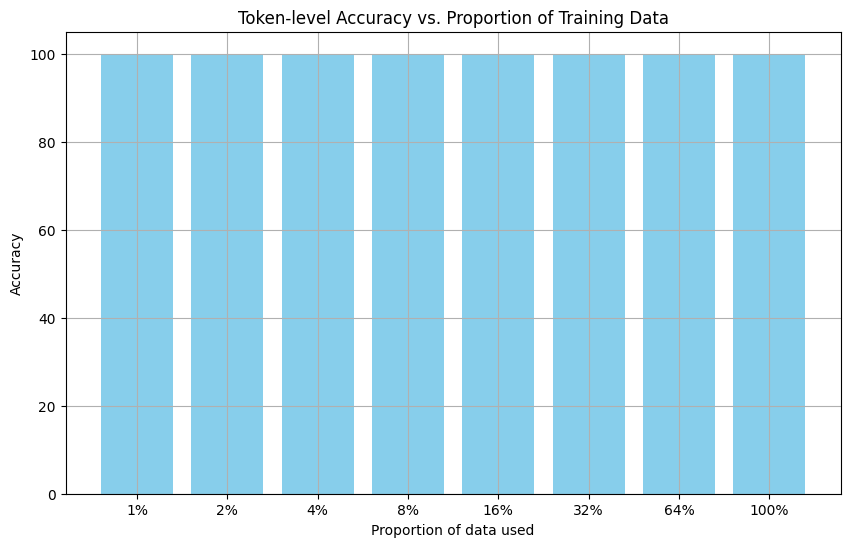

In [ ]:
# Plot results
acc_tok = [99.99850550, 99.99841209, 99.9980073, 99.99800733, 99.99607694, 99.99657510, 99.99661069, 99.99668408]
acc_seq = [99.83261597, 99.82065997, 99.76087996, 99.58153993, 99.56001913, 99.61342260, 99.61057594, 99.62936394 ]
plt.figure(figsize=(10, 6))
plt.bar([f"{int(p * 100)}%" for p in proportions], acc_tok, color = 'skyblue')
plt.xlabel('Proportion of data used')
plt.ylabel('Accuracy')
plt.title('Token-level Accuracy vs. Proportion of Training Data')
#plt.ylim(0, 100)  # Set y-axis limits to 0-100% for clarity
plt.grid(True)
plt.savefig("Token_acc_exp_1.png")


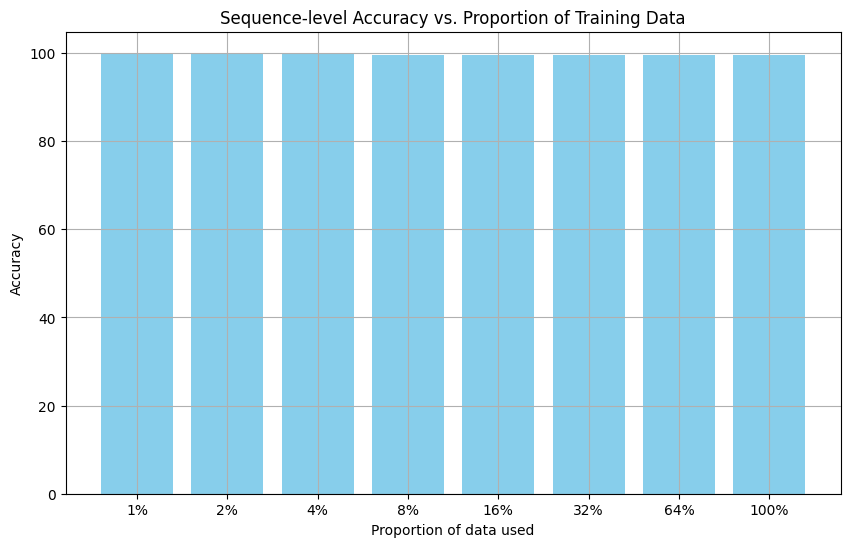

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar([f"{int(p * 100)}%" for p in proportions], acc_seq, color = 'skyblue')
plt.xlabel('Proportion of data used')
plt.ylabel('Accuracy')
plt.title('Sequence-level Accuracy vs. Proportion of Training Data')
#plt.ylim(0, 100)  # Set y-axis limits to 0-100% for clarity
plt.grid(True)
plt.savefig("Seq_acc_exp_1.png")

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.bar([f"{int(p * 100)}%" for p in proportions], token_accuracies, color='skyblue')
plt.xlabel('Proportion of data used')
plt.ylabel('Accuracy')
plt.title('Token-level Accuracy vs. Proportion of Training Data')
#plt.ylim(0, 100)  # Set y-axis limits to 0-100% for clarity
plt.grid(True)
plt.savefig("Token_acc_exp_1.png")

NameError: name 'plt' is not defined

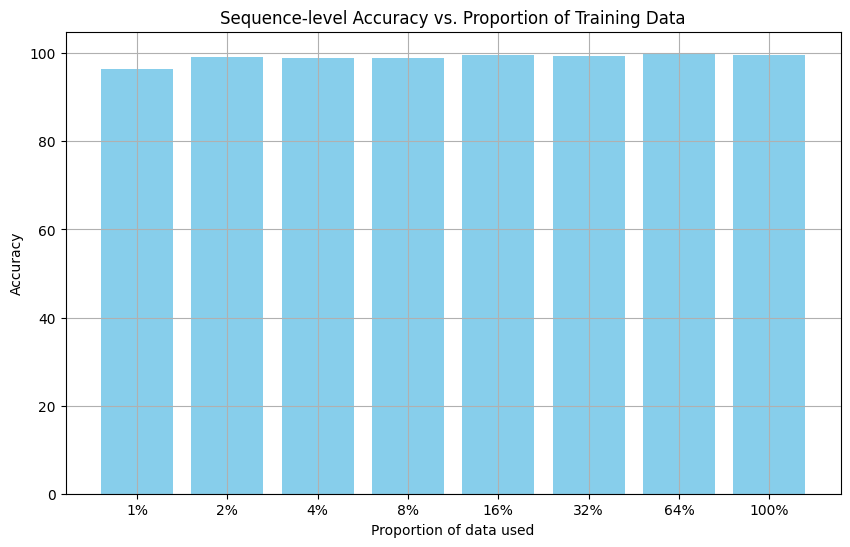

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.bar([f"{int(p * 100)}%" for p in proportions], seq_accuracies, color='skyblue')
plt.xlabel('Proportion of data used')
plt.ylabel('Accuracy')
plt.title('Sequence-level Accuracy vs. Proportion of Training Data')
#plt.ylim(0, 100)  # Set y-axis limits to 0-100% for clarity
plt.grid(True)
plt.savefig("seq_acc_exp_1.png")